# Introduction to Text as Data

## UNM Workshop, April 9, 2018

(following steps adapted from Wilson (2017) authoring guidelines)

Some potential issues:

https://github.com/ContinuumIO/anaconda-issues/issues/7068

## Brainstorm

1. What problem(s) will students learn how to solve?
    - How to load text data into R tidyverse
    - How to begin exploring a text dataset
    - How to extract unigrams, bigrams
    - How to find most popular terms
    - How to perform structured topic modeling
2. What techniques or concepts will students learn?
    - Piping data
    - Stopwords
    - Tokenization
3. What technologies, packages, or functions will students use?
    - `dplyr`
    - `ggplot2`
    - `tidytext`
    - `tidyverse`
    - `stm`
4. What terms or jargon will you define?
    - tidy
    - tidytext
    - document-term matrix / term-document matrix
    - tf-idf
    - topic model
5. What analogies or heuristics will you use?
    - Tidy is a grammar
    - actions are verbs
6. What mistakes or misconceptions do you expect?
    - What a topic is
    - What form data takes as the output of each verb
7. What datasets will you use?
    - Congressional floor speeches?
    - Look at what Grimmer has used
    - Congressional press releases
    - Mills + Wollstonecraft

## Who is this course for?

*Shelly* is a third-year PhD student in political science, studying change in Latin American parliaments. She's rather proficient in some modeling methods and can do a variety of statistical operations in R. Shelly wants to be able to begin using some more popular text as data methods, such as topic modeling, in her research to analyze political texts. The workshop will show her how to collect and organize her data and the beginnings of a topic modeling analysis. Shelly speaks English fluently, although she is hard of hearing.

*Bruno* is a first-year PhD student studying German elections. He's new to R and has only been exposed to what was presented in the preworkshop. He has prior experience in SPSS, however. Bruno wants to apply some kind of text analysis to social media data from German elections, but doesn't quite know where to begin. The workshop will show Bruno how to get started with importing social media text and working with it. English is Bruno's second language, so sometimes he gets stuck on some of the more technical jargon.

## What will students learn along the way?

#### 1. Counting most popular words with `tidytext`

In [12]:
library(tidytext)
library(tidyverse)
library(gutenbergr)
library(ggplot2)

Loading tidyverse: tibble
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [13]:
## A Vindication of the Rights of Woman by Mary Wollstonecraft
vindication <- gutenberg_download(3420)

In [14]:
tidy_vindication <- vindication %>% 
    unnest_tokens(word, text)

tidy_vindication %>%
    anti_join(stop_words) %>%
    count(word, sort = TRUE) %>%
    top_n(10)

Joining, by = "word"
Selecting by n


word,n
women,445
reason,264
mind,232
virtue,198
woman,190
love,173
life,170
nature,147
character,144
respect,133


#### 2. Graphing the prevalence of words in two texts

In [15]:
## A Vindication of the Rights of Woman by Mary Wollstonecraft
#vindication <- gutenberg_download(3420)

## The Subjection of Women by John Stuart Mill
subjection <- gutenberg_download(27083)

In [16]:
tidy_subjection <- subjection %>% 
    unnest_tokens(word, text) %>%
    anti_join(stop_words) %>%
    count(word) %>% 
    mutate(proportion = n / sum(n)) %>%
    top_n(10)

tidy_vindication <- vindication %>% 
    unnest_tokens(word, text) %>%
    anti_join(stop_words) %>%
    count(word) %>% 
    mutate(proportion = n / sum(n)) %>%
    arrange(-proportion) %>%
    top_n(10)

Joining, by = "word"
Selecting by proportion
Joining, by = "word"
Selecting by proportion


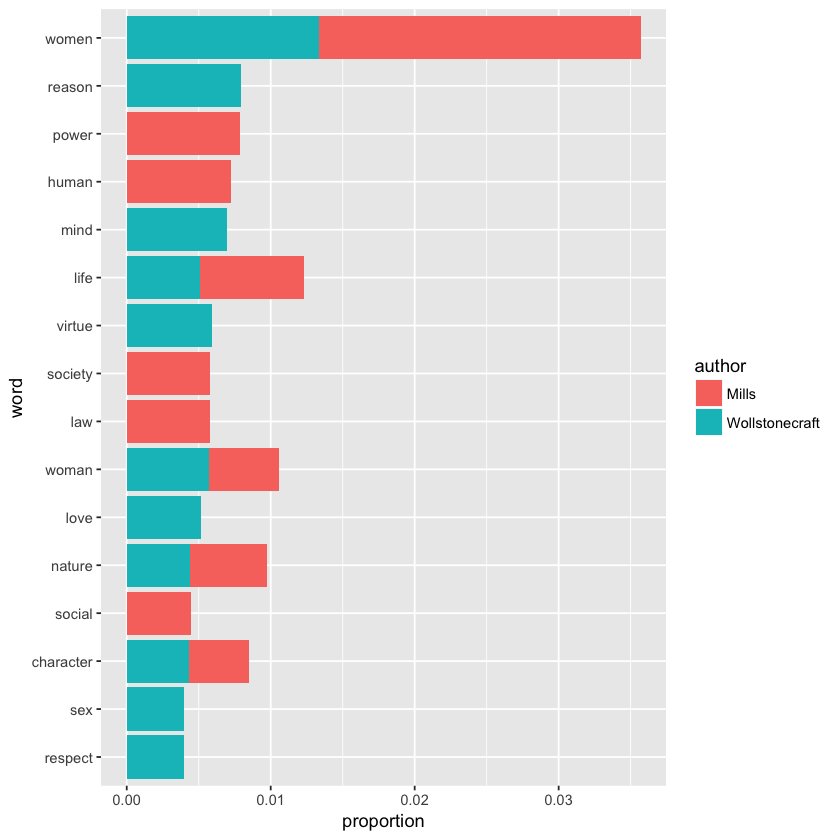

In [17]:
tidy_books <- bind_rows(mutate(tidy_subjection, author = 'Mills'), 
                        mutate(tidy_vindication, author = 'Wollstonecraft'))
tidy_books %>% mutate(word = reorder(word, proportion)) %>% 
    ggplot(aes(word, proportion, fill = author)) + 
    geom_col() + 
    coord_flip()

#### 3. Generating structured topic models from a corpus

In [116]:
library(stm)
library(stringr)

In [118]:
sotu_tweets <- read_csv('sotu-text.csv', col_names = c('tweet'))

Parsed with column specification:
cols(
  tweet = col_character()
)


In [75]:
sotu_tweets$id <- seq(1, nrow(sotu_tweets))

In [121]:
## remove links
## unnest
## remove stopwords
tidy_sotu_tweets <- sotu_tweets %>% 
    mutate(tweet = str_replace(tweet, 'https://.+', '')) %>%
    unnest_tokens(word, tweet) %>%
    anti_join(stop_words) %>%
    filter(word != "sotu")

Joining, by = "word"


In [108]:
sotu_dfm <- tidy_sotu_tweets %>% 
    count(id, word, sort = TRUE) %>%
    cast_dfm(id, word, n)

In [122]:
topic_model <- stm(sotu_dfm, K = 10, 
                   verbose = FALSE, init.type = "Spectral")

In [123]:
summary(topic_model)

A topic model with 10 topics, 1499 documents and a 4833 word dictionary.


Topic 1 Top Words:
 	 Highest Prob: puerto, rico, fema, https, t.co, aid, electricity 
 	 FREX: mandate, electricity, puerto, individual, honor, rico, fema 
 	 Lift: 1,800, 160, 1742, 2019, 695, 9md2zbbmty, abc 
 	 Score: puerto, rico, fema, officially, shut, electricity, maria 
Topic 2 Top Words:
 	 Highest Prob: immigrant, shooter, tonight, people, democrats, church, realdonaldtrump 
 	 FREX: shooter, hook, aurora, charleston, columbine, shooters, theater 
 	 Lift: 365, 4357, 662, 75, 800, analogy, appeal 
 	 Score: shooter, immigrant, church, vegas, hook, aurora, charleston 
Topic 3 Top Words:
 	 Highest Prob: trump, president, speech, people, tonight, national, era 
 	 FREX: 1950s, appears, bygone, goal, normalization, nostalgic, supporters 
 	 Lift: 1️⃣, 2️⃣, 3️⃣, 90, acknowledged, aggressiveness, alexsmith 
 	 Score: trump, era, national, 1950s, appears, bygone, goal 
Topic 4 Top Words:
 	 Highest Prob: immigration, migration, chain, million, reform, based, trump's 
 	 FREX: syst

In [124]:
td_beta <- tidy(topic_model)

Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'that’s' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'that’s' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'that’s' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'that’s' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'that’s' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'that’s' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$la

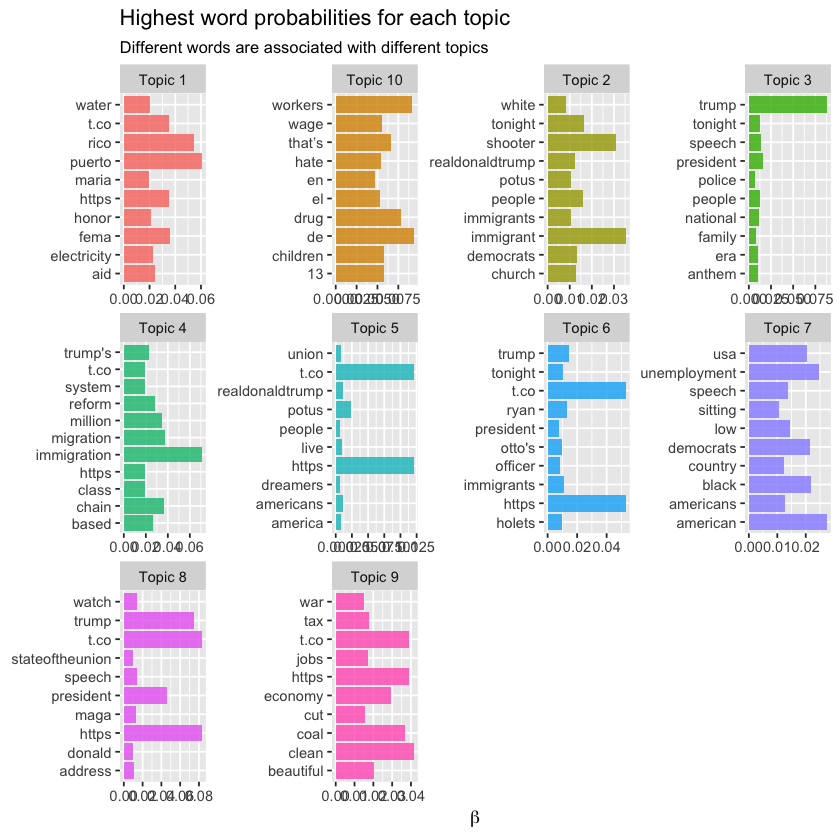

In [125]:
td_beta %>%
    group_by(topic) %>%
    top_n(10, beta) %>%
    ungroup() %>%
    mutate(topic = paste0("Topic ", topic), term) %>%
    ggplot(aes(term, beta, fill = as.factor(topic))) +
    geom_col(alpha = 0.8, show.legend = FALSE) +
    facet_wrap(~ topic, scales = "free") +
    coord_flip() +
    labs(x = NULL, y = expression(beta),
         title = "Highest word probabilities for each topic",
         subtitle = "Different words are associated with different topics")

### Step 4: How are the concepts connected?